In [140]:
import os
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers, Model

from utils import manage_outlier

def seed_everything(seed:int=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

warnings.filterwarnings('ignore')
seed_everything()

In [197]:
df = pd.read_csv('./dataset/ff.csv')
df = df[df['BE5_1'].notna()]
# drops = df.isna().sum().sort_values(ascending=False) / df.shape[0] * 100
# df = df[drops[drops.values <= 10].index]
# # feature importance 기반 변수 제거(1차)
# df.drop(['LQ_1EQL', 'LQ_2EQL', 'LQ_3EQL', 'LQ_4EQL', 'LQ_5EQL'], axis=1, inplace=True)
# # corr matrix 기반 변수 제거(2차)
# df.drop(['EC1_1'], axis=1, inplace=True)
# # feature importance 기반 변수 제거(3차)
# df.drop(['cage', 'LQ1_sb', 'LQ1_mn', 'LQ4_00'], axis=1, inplace=True)
# # feture importance 기반 변수 제거(4차)
# df.drop(['BD1', 'mh_stress', 'BS3_1'], axis=1, inplace=True)
# # feture importance 기반 변수 제거(5차)
# df.drop(['BO1_1', 'BO2_1'], axis=1, inplace=True)

In [198]:
# 1차년도
NUMERIC = ['HE_FEV1FVC', 'age', 'Total_slp_wk']
CATEGORICAL = ['sex', 'occp', 'EC1_1', 'cfam', 'marri_1', 'BH9_11', 'HE_DM', 'DC6_dg', 'DF2_dg', 'HE_HPdg', 'BP5']
ONE_HOT = ['BS3_1', 'edu', 'BP1', 'D_1_1', 'LQ_1EQL', 'LQ_2EQL', 'LQ_3EQL', 'LQ_4EQL', 'LQ_5EQL', 'BO1_1', 'BO2_1']
# 2차년도
NUMERIC2 = ['DI1_ag', 'DE1_ag', 'LQ1_mn', 'BS6_2_1', 'BS6_3']
CATEGORICAL2 = ['DI1_pt', 'DE1_pt', 'DE1_3', 'BH1', 'BH2_61', 'LQ4_00', 'LQ4_05', 'LQ1_sb', 'MO1_wk', 'HE_cough1', 'HE_sput1', 'BD1', 'BD7_5', 'BP6_10', 'BP6_31']
ONE_HOT2 = ['DI1_2', 'EC_pedu_1', 'EC_pedu_2', 'BS5_1', 'BD7_4']
# 생성변수
NUMERIC3 = ['eq_5d']
CATEGORICAL3 = ['sm_present', 'mh_stress']
ONE_HOT3 = ['cage']
# Targets
TARGETS = ['BE3_31', 'BE5_1']

f_NUMERIC = (NUMERIC + NUMERIC2 + NUMERIC3).copy()
f_CATEGORICAL = (CATEGORICAL + CATEGORICAL2 + CATEGORICAL3).copy()
f_ONE_HOT = (ONE_HOT + ONE_HOT2 + ONE_HOT3).copy()
f_CATEGORICAL.append('BE3_31')

In [202]:
for value in f_NUMERIC:
    if value not in df.columns:
        print(value)
        f_NUMERIC.remove(value)

for value in f_CATEGORICAL:
    if value not in df.columns:
        print(value)
        f_CATEGORICAL.remove(value)

for value in f_ONE_HOT:
    if value not in df.columns:
        print(value)
        f_ONE_HOT.remove(value)

In [203]:
# 결측치 처리
for col in f_NUMERIC:
    df[col].fillna(0, inplace=True)
for col in f_CATEGORICAL:
    df[col].fillna(0, inplace=True)
for col in f_ONE_HOT:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [204]:
X = df.drop('BE5_1', axis=1)
y = df['BE5_1']

X_numeric = X[f_NUMERIC]
X_categorical = X[f_CATEGORICAL]
X_onehot = X[f_ONE_HOT]
X_onehot = pd.get_dummies(X_onehot, dtype=float)

X = pd.concat([X_numeric, X_categorical], axis=1)
X = pd.concat([X, X_onehot], axis=1)

# split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=.2, stratify=y, random_state=42)

# scaling
scaler = MinMaxScaler()
train_X[f_NUMERIC] = scaler.fit_transform(train_X[f_NUMERIC])
test_X[f_NUMERIC] = scaler.transform(test_X[f_NUMERIC])

In [205]:
smote = SMOTE(random_state=42)
sm_X, sm_y = smote.fit_resample(train_X, train_y)

In [206]:
print(f'train shape: {train_X.shape, train_y.shape}')
print(f'train(over) shape: {sm_X.shape, sm_y.shape}')
print(f'test shape: {test_X.shape, test_y.shape}')

train shape: ((2976, 93), (2976,))
train(over) shape: ((12774, 93), (12774,))
test shape: ((744, 93), (744,))


In [166]:
model = keras.Sequential([
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(1),
    keras.layers.ReLU(max_value=5.0)
])

# 모델 컴파일
model.compile(optimizer=keras.optimizers.AdamW(learning_rate=0.0001),
              loss='mse',
              metrics=['mse', 'mae'])

callback = keras.callbacks.ModelCheckpoint('./auto_reg.h5', mode='min', monitor='val_mae', save_best_only=True)

# 모델 훈련
history = model.fit(
    sm_X, sm_y, 
    epochs=60, batch_size=128, 
    validation_data=(test_X, test_y),
    callbacks=[callback]
)

Epoch 1/60
100/100 [==============================] - 2s 11ms/step - loss: 3.2633 - mse: 3.2633 - mae: 1.5090 - val_loss: 4.5930 - val_mse: 4.5930 - val_mae: 2.0002
Epoch 2/60
100/100 [==============================] - 1s 9ms/step - loss: 2.3502 - mse: 2.3502 - mae: 1.2843 - val_loss: 3.7277 - val_mse: 3.7277 - val_mae: 1.7336
Epoch 3/60
100/100 [==============================] - 1s 8ms/step - loss: 2.1283 - mse: 2.1283 - mae: 1.1828 - val_loss: 3.9708 - val_mse: 3.9708 - val_mae: 1.7447
Epoch 4/60
100/100 [==============================] - 1s 8ms/step - loss: 1.9365 - mse: 1.9365 - mae: 1.1031 - val_loss: 4.0674 - val_mse: 4.0674 - val_mae: 1.7558
Epoch 5/60
100/100 [==============================] - 1s 8ms/step - loss: 1.7313 - mse: 1.7313 - mae: 1.0220 - val_loss: 3.7440 - val_mse: 3.7440 - val_mae: 1.6385
Epoch 6/60
100/100 [==============================] - 1s 8ms/step - loss: 1.5201 - mse: 1.5201 - mae: 0.9304 - val_loss: 3.7739 - val_mse: 3.7739 - val_mae: 1.5932
Epoch 7/60
100/

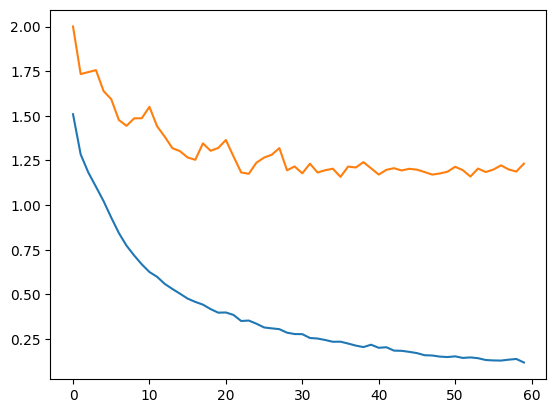

In [167]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])

In [169]:
temp_y = test_y[test_y >= 1.0]
temp_X = test_X.loc[temp_y.index]

In [170]:
md = keras.models.load_model('./auto_reg.h5')
pred = np.squeeze(md.predict(temp_X))
print(
    f'mse: {mean_squared_error(temp_y, pred)}',
    f'mae: {mean_absolute_error(temp_y, pred)}',
    sep='\n'
)

7/7 [==============================] - 0s 3ms/step
mse: 7.811878633119971
mae: 2.332995350388766


In [193]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0  # 실제값이 0인 경우를 제외

    # 실제값이 0이 아닌 데이터에 대해 MAPE를 계산
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100


def mape_with_zeros(y_true, y_pred, epsilon=1e-10):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # 실제 값이 0인 경우를 처리하기 위해 epsilon을 더함
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100


def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_pred - y_true) / denominator
    diff[denominator == 0] = 0  # 0으로 나누는 것을 방지
    return 100.0 * np.mean(diff)


def smape_with_zeros(y_true, y_pred, epsilon=1e-10):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred) + epsilon) / 2.0

    # 분모가 0이 되는 것을 방지하기 위해 epsilon을 추가
    diff = np.abs(y_pred - y_true) / denominator
    return 100.0 * np.mean(diff)

In [196]:
from sklearn.metrics import r2_score
md = keras.models.load_model('./auto_reg.h5')
pred = np.squeeze(md.predict(test_X))
print(
    f'mse: {mean_squared_error(test_y, pred)}',
    f'mae: {mean_absolute_error(test_y, pred)}',
    # f'mape: {mean_absolute_percentage_error(test_y+1, pred+1)*100:.2f}',
    f'mape: {mape_with_zeros(test_y, pred)}',
    f'smape: {smape_with_zeros(test_y, pred)}',
    f'r2: {r2_score(test_y, pred)}',
    sep='\n'
)

24/24 [==============================] - 0s 3ms/step
mse: 3.5366036082542585
mae: 1.158122964799204
mape: 496480469138.3803
smape: 92.20524021363471
r2: -0.1681313268733866


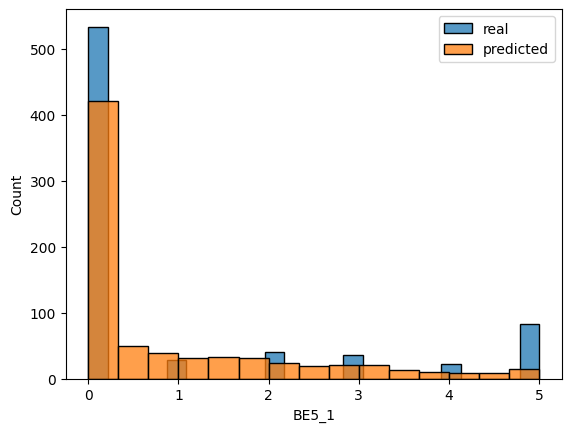

In [178]:
sns.histplot(test_y)
sns.histplot(pred)
plt.legend(['real', 'predicted'])

(array([  0.,   0.,   0.,   0.,   0., 533.,   0.,   0.,   0.,   0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

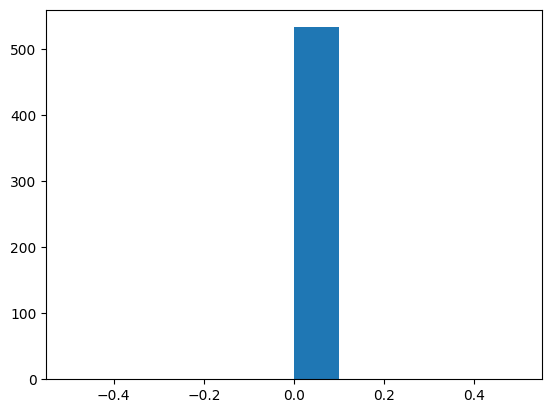

In [117]:
plt.hist(temp_y)